# Data Science Challenge

In [1]:
# If you'd like to install packages that aren't installed by default, uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere

#import sys
#!{sys.executable} -m pip install <package list>

In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns

pd.set_option("display.max_columns", 101)

## Data Description

Column | Description
:---|:---
`id` | The unique ID assigned to every restaurant.
`name` | The name of the restaurant.
`location` | The location of the restaurant.
`phone` | The phone number of the restaurant.
`table_bookings` | Indicates if the restaurant takes online reservations.
`online_ordering` | Indicates if the restaurant takes online orders.
`restaurant_type` | The type of restaurant. Values are Casual Dining, Cafe, Quick Bites, etc.
`restaurant_operation` | The primary operation of the restaurant. For example, ‘Delivery’.
`primary_cuisine` | The name of the primary cuisine offered by the restaurant. Values are American, Mexican, etc.
`popular_dishes` | The number of popular dishes offered by the restaurant.
`cuisines_offered` | The number of cuisines offered by the restaurant.
`rating` | The rating of the restaurant.
`votes` | The number of customer votes received by the restaurant
`dining_cost` | It indicates if the classification of dining costs at the restaurant. Values are 0 (Budget), 1 (Expensive).

## Data Wrangling & Visualization

In [2]:
# Dataset is already loaded below
data = pd.read_csv("train.csv")

In [3]:
data.head()

,id,name,table_bookings,online_ordering,location,rating,votes,phone,restaurant_type,restaurant_operation,popular_dishes,cuisines_offered,primary_cuisine,dining_cost
0,19340,Plan B,No,No,Greenwich,4.2/5,1651.0,8041609100,Casual Dining,Pubs and bars,7.0,4.0,American,1.0
1,31103,Hunan,No,Yes,Tribeca,4.3 /5,2248.0,080 25520154,Casual Dining,Dine-out,7.0,3.0,Chinese,1.0
2,17563,Lavonne,No,No,Greenwich,4.4/5,1095.0,9740954505,Cafe,Cafes,7.0,2.0,Snacks,1.0
3,11192,Ambur Star Dum Burger,Yes,No,Chelsea,3.4/5,17.0,"7200110202\r, 9840017416",Quick Bites,Dine-out,1.0,1.0,Italian,0.0
4,21324,Dadi's Dum Burger,Yes,Yes,Lower Manhattan,4.1 /5,2727.0,"7090999991, 7090599999",Casual Dining,Dine-out,7.0,3.0,Italian,1.0


In [4]:
#Explore columns
data.columns

Index(['id', 'name', 'table_bookings', 'online_ordering', 'location', 'rating',
       'votes', 'phone', 'restaurant_type', 'restaurant_operation',
       'popular_dishes', 'cuisines_offered', 'primary_cuisine', 'dining_cost'],
      dtype='object')

In [5]:
#Description
data.describe()

,id,votes,popular_dishes,cuisines_offered,dining_cost
count,2435.000000,2391.000000,2316.000000,2413.00000,2435.000000
mean,24562.075975,486.398996,3.569948,2.58765,0.520329
std,14043.041772,1294.380994,2.816004,1.29975,0.499689
min,53.000000,0.000000,1.000000,1.00000,0.000000
25%,11191.000000,9.500000,1.000000,2.00000,0.000000
50%,22754.000000,66.000000,1.500000,2.00000,1.000000
75%,34879.000000,383.000000,7.000000,3.00000,1.000000
max,51708.000000,14723.000000,7.000000,8.00000,1.000000


In [6]:
data.isna().mean()

id                      0.000000
name                    0.000000
table_bookings          0.000000
online_ordering         0.000000
location                0.000000
rating                  0.144148
votes                   0.018070
phone                   0.013963
restaurant_type         0.045996
restaurant_operation    0.008214
popular_dishes          0.048871
cuisines_offered        0.009035
primary_cuisine         0.006982
dining_cost             0.000000
dtype: float64

In [7]:
"""
Droping name and phone as it does not make any contribution in modelling.
"""
data.drop([ 'name', 'phone'], axis = 1, inplace = True)

In [8]:
"""
Replacing Yes and No with the integers
"""
replace_map = {
    "table_bookings": {
        "Yes": 1,
        "No": 0
    },
    "online_ordering": {
        "Yes": 1,
        "No": 0
    },
    "rating":{
        "NEW": np.nan,
        "-": np.nan
    }
}
data.replace(replace_map, inplace = True)

In [9]:
"""
Converting ratings to integers
"""
data['rating'] = data['rating'].apply(lambda x:float(x.split('/')[0].strip()) if not pd.isna(x) else x)

In [10]:
"""
Imputing missing values by replacing them with median for each region.
"""

data['primary_cuisine'] = data['primary_cuisine'].fillna(data['primary_cuisine'].mode()[0])
data['rating'] = data.groupby(['primary_cuisine'])['rating'].transform(lambda x: x.fillna(x.median()))
data['votes'] = data.groupby(['primary_cuisine'])['votes'].transform(lambda x: x.fillna(x.median()))
data['popular_dishes'] = data.groupby(['primary_cuisine'])['popular_dishes'].transform(lambda x: x.fillna(x.median()))
data['cuisines_offered'] = data.groupby(['primary_cuisine'])['cuisines_offered'].transform(lambda x: x.fillna(x.median()))

data['restaurant_type'] = data.groupby(['primary_cuisine'])['restaurant_type'].transform(lambda x: x.fillna(x.mode()[0]))
data['restaurant_operation'] = data.groupby(['primary_cuisine'])['restaurant_operation'].transform(lambda x: x.fillna(x.mode()[0]))

In [11]:
data.head(2)

,id,table_bookings,online_ordering,location,rating,votes,restaurant_type,restaurant_operation,popular_dishes,cuisines_offered,primary_cuisine,dining_cost
0,19340,0,0,Greenwich,4.2,1651.0,Casual Dining,Pubs and bars,7.0,4.0,American,1.0
1,31103,0,1,Tribeca,4.3,2248.0,Casual Dining,Dine-out,7.0,3.0,Chinese,1.0


## Visualization, Modeling, Machine Learning

Can you build a model that can categorizes restaurants into 'Budget' and 'Expensive' and identify how different features influence the decision? Please explain your findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model would be evaluated on the basis of Accuracy.**
- **Read the test.csv file and prepare features for testing.**

In [12]:
#Loading Test data
test_data=pd.read_csv('test.csv')
test_data.head()

,id,name,table_bookings,online_ordering,location,rating,votes,phone,restaurant_type,restaurant_operation,popular_dishes,cuisines_offered,primary_cuisine
0,19281,Plan B,No,No,Greenwich,4.2/5,1651.0,8041609100,Casual Dining,Drinks & nightlife,7.0,4.0,American
1,16095,Mom's Kitchen,No,No,East Village,NaN,0.0,"9738732072, 9742716121",Delivery,Delivery,1.0,1.0,American
2,42040,Keys Cafe - Keys Hotel,No,No,Chinatown,2.8 /5,161.0,080 39451000\n 8884038484,Casual Dining,Dine-out,7.0,3.0,Chinese
3,18753,Smally's Resto Cafe,Yes,No,Greenwich,4.0/5,401.0,"080 48149349, 9632015858",Cafe,Dine-out,7.0,5.0,Snacks
4,21065,Fabcafe,No,Yes,Chelsea,3.8 /5,11.0,8050403072,Cafe,Dine-out,1.0,2.0,Snacks


In [13]:
"""
Pre-processing test data
"""
test_id = test_data['id']
test_data.drop(['id' ,'name', 'phone'], axis = 1, inplace = True)
test_data.replace(replace_map, inplace = True)

test_data['rating'] = test_data['rating'].apply(lambda x:float(x.split('/')[0].strip()) if not pd.isna(x) else x)
test_data['restaurant_type'] = test_data['restaurant_type'].apply(lambda x:x.split(',')[0] if not pd.isna(x) else x)


test_data['primary_cuisine'] = test_data['primary_cuisine'].fillna(data['primary_cuisine'].mode()[0])
test_data['rating'] = test_data['rating'].fillna(data['rating'].median())
test_data['votes'] = test_data['votes'].fillna(data['votes'].median())
test_data['popular_dishes'] = test_data['popular_dishes'].fillna(data['popular_dishes'].median())
test_data['cuisines_offered'] = test_data['cuisines_offered'].fillna(data['cuisines_offered'].median())

test_data['restaurant_type'] = test_data['restaurant_type'].fillna(data['restaurant_type'].mode()[0])
test_data['restaurant_operation'] = test_data['restaurant_operation'].fillna(data['restaurant_operation'].mode()[0])

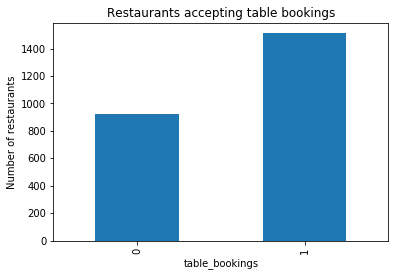

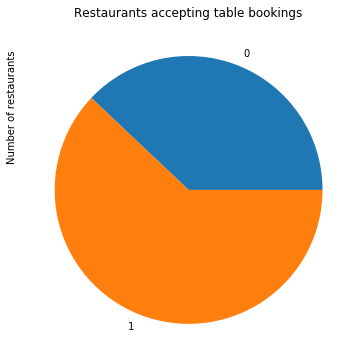

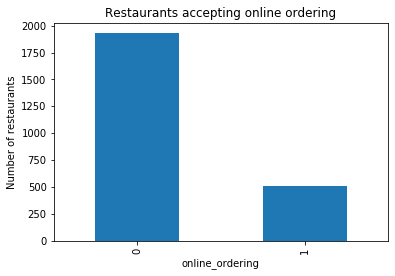

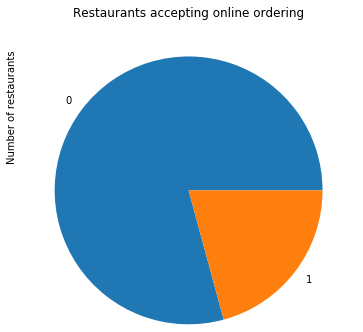

In [14]:
"""
Analyzing table_bookings and online_ordering features of the restaurants.

"""

data.groupby(['table_bookings'])['id'].count().plot(kind='bar',  
  ylim=0, title= 'Restaurants accepting table bookings')
plt.ylabel('Number of restaurants', fontsize = 10);
plt.show()

data.groupby(['table_bookings'])['id'].count().plot(kind='pie',  
  ylim=0, title= 'Restaurants accepting table bookings')
plt.ylabel('Number of restaurants', fontsize = 10);
plt.show()

data.groupby(['online_ordering'])['id'].count().plot(kind='bar',  
  ylim=0, title= 'Restaurants accepting online ordering')
plt.ylabel('Number of restaurants', fontsize = 10);
plt.show()

data.groupby(['online_ordering'])['id'].count().plot(kind='pie',  
  ylim=0, title= 'Restaurants accepting online ordering')
plt.ylabel('Number of restaurants', fontsize = 10);
plt.show()

Inferences

1. Almost 60 percent of the restaurants provide table booking facility.
2. Almost 20 percent of the restaurants provide online ordering facility.

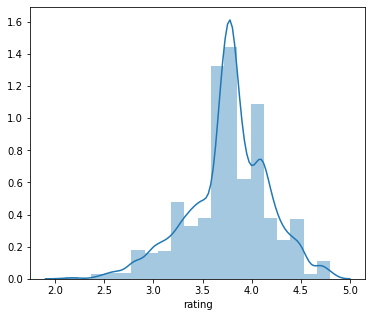

In [15]:
"""
Analyzing ratings.
"""

plt.figure(figsize=(6,5))
rating=data['rating']
sns.distplot(rating,bins=20)

Inferences

1. More than 60% of the restaurants have rating between 3 and 4.2. 
2. Restaurants having rating more than 4.5 are rare.

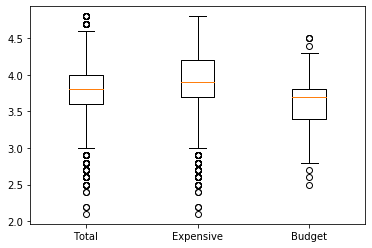

In [16]:
"""
Distribution of rating wrt to dining costs.
"""

total = data['rating'].tolist()
expensive_r = data[data['dining_cost'] == 1]['rating'].tolist()
budget_r = data[data['dining_cost'] == 0]['rating'].tolist()
labels = ["Total", "Expensive", "Budget"]
plt.boxplot([total, expensive_r, budget_r])
plt.xticks(list(range(1,len(labels)+1)), labels)
plt.show()

Inferences

1. Expensive restaurants have higher median rating than budget ones.
2. Expensive restaurants have higher lower outliers as compared to the budget ones.

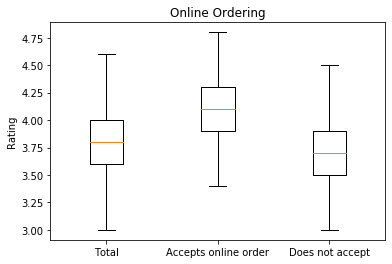

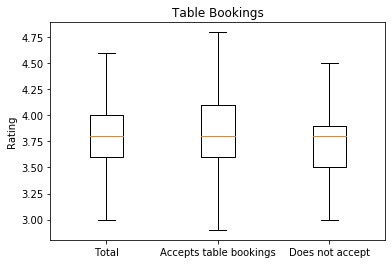

In [17]:
"""
How does facilities like online ordering and table booking 
effects ratings earned by the restaurants. 
"""

total = data['rating'].tolist()
expensive_r = data[data['online_ordering'] == 1]['rating'].tolist()
budget_r = data[data['online_ordering'] == 0]['rating'].tolist()
labels = ["Total", "Accepts online order", "Does not accept"]
plt.boxplot([total, expensive_r, budget_r], sym = '')
plt.xticks(list(range(1,len(labels)+1)), labels)
plt.title("Online Ordering")
plt.ylabel("Rating")
plt.show()

plt.clf()
total = data['rating'].tolist()
expensive_r = data[data['table_bookings'] == 1]['rating'].tolist()
budget_r = data[data['table_bookings'] == 0]['rating'].tolist()
labels = ["Total", "Accepts table bookings", "Does not accept"]
plt.boxplot([total, expensive_r, budget_r], sym ='')
plt.xticks(list(range(1,len(labels)+1)), labels)
plt.title("Table Bookings")
plt.ylabel("Rating")
plt.show()

Inferences 

1. Restaurants offering online ordering has higher median rating while the facilities like table bookings slightly influence median ratings. 

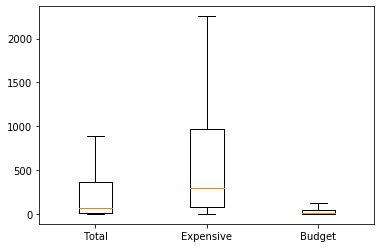

In [18]:
"""
Distribution of votes wrt to dining costs.
"""

total = data['votes'].tolist()
expensive_r = data[data['dining_cost'] == 1]['votes'].tolist()
budget_r = data[data['dining_cost'] == 0]['votes'].tolist()
labels = ["Total", "Expensive", "Budget"]
plt.boxplot([total, expensive_r, budget_r], sym = '')
plt.xticks(list(range(1,len(labels)+1)), labels)
plt.show()

Inferences

1. Expensive resturants gathers more votes than Budget ones. 

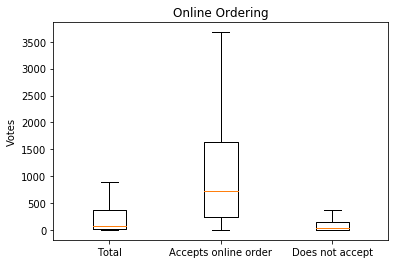

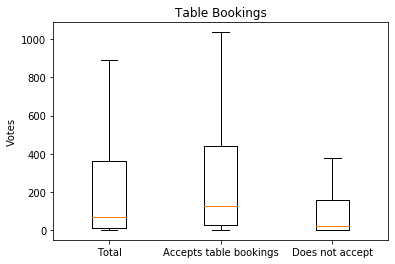

In [19]:
"""
How does facilities like online ordering and table booking 
effects votes earned by the restaurants. 
"""

total = data['votes'].tolist()
expensive_r = data[data['online_ordering'] == 1]['votes'].tolist()
budget_r = data[data['online_ordering'] == 0]['votes'].tolist()
labels = ["Total", "Accepts online order", "Does not accept"]
plt.boxplot([total, expensive_r, budget_r], sym = '')
plt.xticks(list(range(1,len(labels)+1)), labels)
plt.title("Online Ordering")
plt.ylabel("Votes")
plt.show()


plt.clf()
total = data['votes'].tolist()
expensive_r = data[data['table_bookings'] == 1]['votes'].tolist()
budget_r = data[data['table_bookings'] == 0]['votes'].tolist()
labels = ["Total", "Accepts table bookings", "Does not accept"]
plt.boxplot([total, expensive_r, budget_r], sym ='')
plt.xticks(list(range(1,len(labels)+1)), labels)
plt.title("Table Bookings")
plt.ylabel("Votes")
plt.show()

Inference

1.  Restaurants accepting online orders and table bookings has higher median votes than those with no online order or table booking facility.

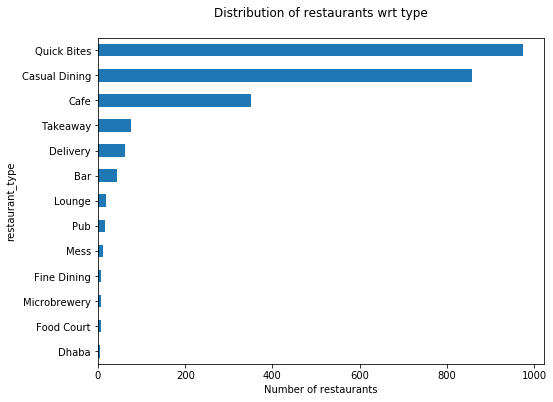

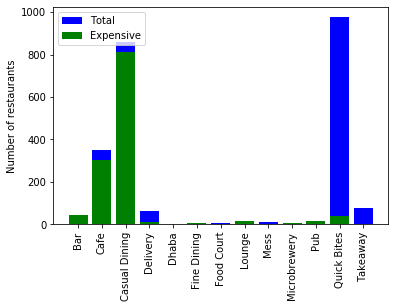

In [20]:
"""
Exploring restaurant types.
"""


fig = plt.figure(figsize=(8,6))
data.groupby('restaurant_type').id.count().sort_values().plot.barh(
    ylim=0, title= 'Distribution of restaurants wrt type\n')
plt.xlabel('Number of restaurants', fontsize = 10);
plt.show()

plt.clf()
y1 = data.groupby(['restaurant_type'])['dining_cost'].count().tolist()
y2 = data.groupby(['restaurant_type'])['dining_cost'].sum().tolist()
labels = data.groupby(['restaurant_type'])['dining_cost'].count().reset_index()['restaurant_type'].tolist()
plt.bar(labels, y1, color = 'b', label = 'Total')
plt.bar(labels, y2, color = 'g', label = 'Expensive')
plt.xticks(rotation=90)
plt.ylabel("Number of restaurants")
plt.legend(loc = 'upper left')

Inferences

1. Most restaurants follows Quick Bites and Casual Dining types.
2. Most of the Quick Bites resturants are Budget while most of the Casual Dinings, Cafes and Bars are expensive. 

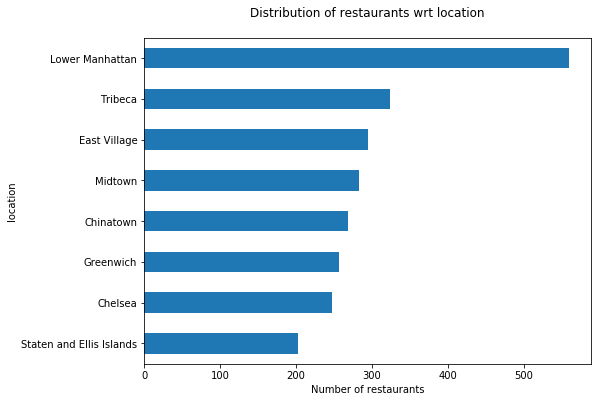

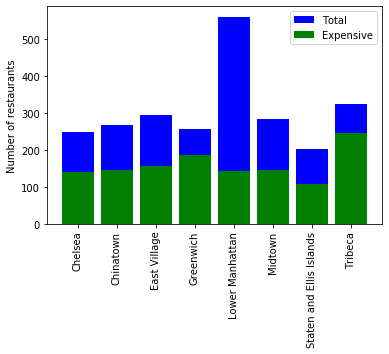

In [21]:
"""
Exploring locations with most restaurants.
"""


fig = plt.figure(figsize=(8,6))
data.groupby('location').id.count().sort_values().plot.barh(
    ylim=0, title= 'Distribution of restaurants wrt location\n')
plt.xlabel('Number of restaurants', fontsize = 10);
plt.show()

plt.clf()
y1 = data.groupby(['location'])['dining_cost'].count().tolist()
y2 = data.groupby(['location'])['dining_cost'].sum().tolist()
labels = data.groupby(['location'])['dining_cost'].count().reset_index()['location'].tolist()
plt.bar(labels, y1, color = 'b', label = 'Total')
plt.bar(labels, y2, color = 'g', label = 'Expensive')
plt.xticks(rotation=90)
plt.ylabel("Number of restaurants")
plt.legend(loc = 'upper right')

Inferences

1. Lower Manhattan has most number of resturants followed by Staten and Ellis Islands.
2. More than 50% of the restaurants in all the locations except Lower Manhattan are expensive. 

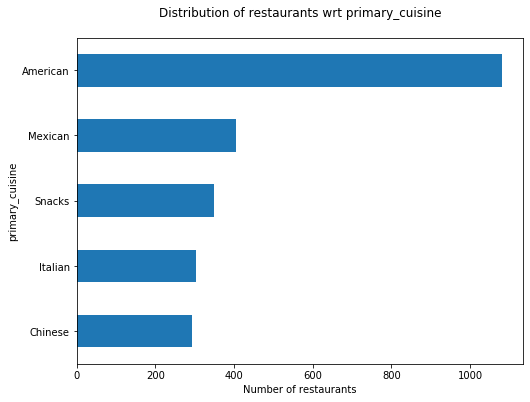

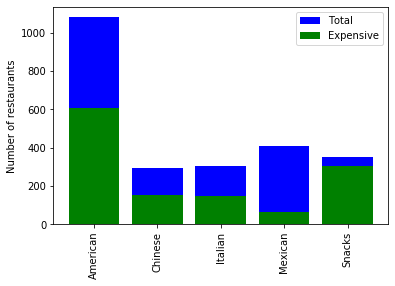

In [22]:
"""
Exploring locations with most restaurants.
"""


fig = plt.figure(figsize=(8,6))
data.groupby('primary_cuisine').id.count().sort_values().plot.barh(
    ylim=0, title= 'Distribution of restaurants wrt primary_cuisine\n')
plt.xlabel('Number of restaurants', fontsize = 10)
plt.show()

plt.clf()
y1 = data.groupby(['primary_cuisine'])['dining_cost'].count().tolist()
y2 = data.groupby(['primary_cuisine'])['dining_cost'].sum().tolist()
labels = data.groupby(['primary_cuisine'])['dining_cost'].count().reset_index()['primary_cuisine'].tolist()
plt.bar(labels, y1, color = 'b', label = 'Total')
plt.bar(labels, y2, color = 'g', label = 'Expensive')
plt.xticks(rotation=90)
plt.ylabel("Number of restaurants")
plt.legend(loc = 'upper right')

Inferences

1. American cuisine dominates followed by Mexican.
2. More than 50% of restaurants serving American, Chineese and Snacks are expensive.
3. Most of the Mexican resturants are Budget. 

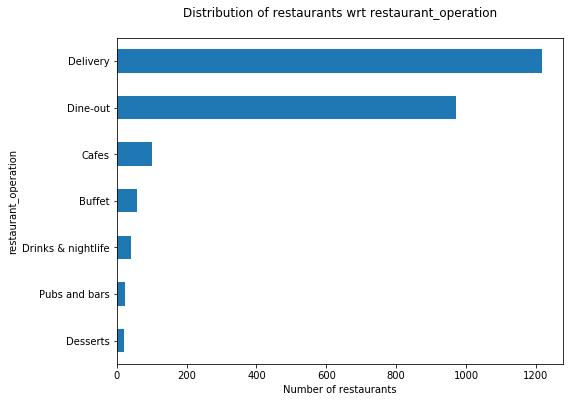

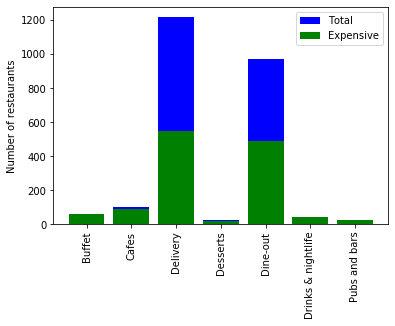

In [23]:
"""
Exploring operations with most restaurants.
"""


fig = plt.figure(figsize=(8,6))
data.groupby('restaurant_operation').id.count().sort_values().plot.barh(
    ylim=0, title= 'Distribution of restaurants wrt restaurant_operation\n')
plt.xlabel('Number of restaurants', fontsize = 10)
plt.show()

plt.clf()
y1 = data.groupby(['restaurant_operation'])['dining_cost'].count().tolist()
y2 = data.groupby(['restaurant_operation'])['dining_cost'].sum().tolist()
labels = data.groupby(['restaurant_operation'])['dining_cost'].count().reset_index()['restaurant_operation'].tolist()
plt.bar(labels, y1, color = 'b', label = 'Total')
plt.bar(labels, y2, color = 'g', label = 'Expensive')
plt.xticks(rotation=90)
plt.ylabel("Number of restaurants")
plt.legend(loc = 'upper right')

Inferences

1. Most popular restaurant operation is Delivery followed by Dine-out.
2. Less than 50% of Delivery restaurants are expensive. 

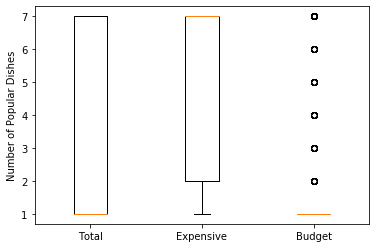

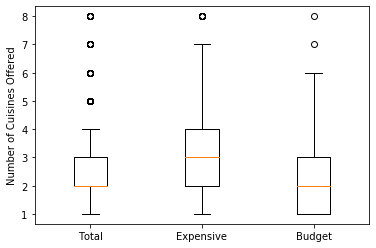

In [24]:
"""
Variation of the number of popular dishes and cuisines offered across 
Expesnive and Budget Restaurants. 

"""

total = data['popular_dishes'].tolist()
expensive_r = data[data['dining_cost'] == 1]['popular_dishes'].tolist()
budget_r = data[data['dining_cost'] == 0]['popular_dishes'].tolist()
labels = ["Total", "Expensive", "Budget"]
plt.boxplot([total, expensive_r, budget_r])
plt.xticks(list(range(1,len(labels)+1)), labels)
plt.ylabel("Number of Popular Dishes")
plt.show()

total = data['cuisines_offered'].tolist()
expensive_r = data[data['dining_cost'] == 1]['cuisines_offered'].tolist()
budget_r = data[data['dining_cost'] == 0]['cuisines_offered'].tolist()
labels = ["Total", "Expensive", "Budget"]
plt.boxplot([total, expensive_r, budget_r])
plt.xticks(list(range(1,len(labels)+1)), labels)
plt.ylabel("Number of Cuisines Offered")
plt.show()

Inferences

1. Budget restaurants have less number of popular dishes as well as serves a limited cuisines.

In [25]:
data.drop('id', axis =1, inplace =True)

In [26]:
"""
One hot encoding
"""

one_hot = ['location', 'restaurant_type', 'restaurant_operation', 'primary_cuisine']
data = pd.get_dummies(data, columns=one_hot)
test_data = pd.get_dummies(test_data, columns=one_hot)

In [27]:
X_train,X_valid,Y_train,Y_valid=train_test_split(
    data.drop(['dining_cost'], axis = 1),
    data[['dining_cost']],
    train_size=0.8)

In [28]:
'''
Model-I: Logistic Regression for binary classification
'''
model = LogisticRegression()
clf = model.fit(X_train, Y_train)
Y_pred = clf.predict(X_valid)
accuracy_score(Y_valid,Y_pred)

/Users/divyanshjain/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/divyanshjain/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9404517453798767

In [29]:
'''
Model-II: Using Xgboost for classification.
'''
model = XGBClassifier()
model.fit(X_train, Y_train) 

Y_pred=model.predict(X_valid)
accuracy_score(Y_valid,Y_pred)

/Users/divyanshjain/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/divyanshjain/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.946611909650924



**The management wants to know what are the most important features for your model.  Can you tell them?**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


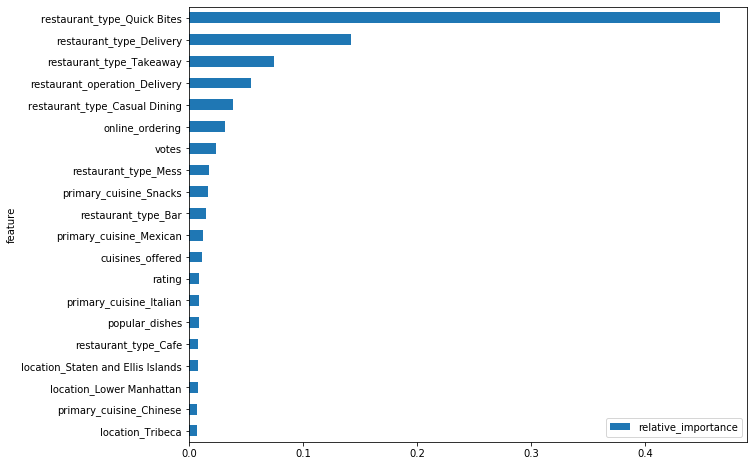

In [30]:
feature_imp=pd.DataFrame()
for feature,imp in zip(X_train.columns,model.feature_importances_):
    temp=pd.DataFrame([feature,imp]).T
    feature_imp=feature_imp.append(temp)
feature_imp.columns=['feature','relative_importance']
feature_imp.sort_values(by='relative_importance',inplace=True)
feature_imp.set_index('feature',inplace=True)
feature_imp.iloc[-20:,:].plot(kind='barh',figsize=(10,8))
plt.show()

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (`test.csv`), you must predict the value of the `dining_cost` variable. You should submit a CSV file with a header row and one row per test entry. The file (submissions.csv) should have exactly 2 columns:

The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **dining_cost**

In [31]:
submission=model.predict(test_data)

In [32]:
submission_df=pd.DataFrame(
{
    'id':test_id,
    'dining_cost':submission
})

In [33]:
#Submission
submission_df.to_csv('submissions.csv',index=False)

---